<div class="markdown-google-sans">

# **The Fabrics Dataset**



## **1. Define problem**


<div class="markdown-google-sans">


The Fabrics Dataset consists of about 2000 samples of garments and fabrics. A small patch of each surface has been captured under 4 different illumination conditions using a custom made, portable photometric stereo sensor. All images have been acquired "in the field" (at clothes shops) and the dataset reflects the distribution of fabrics in real world, hence it is not balanced. The majority of clothes are made of specific fabrics, such as cotton and polyester, while some other fabrics, such as silk and linen, are more rare. Also, a large number of clothes are not composed of a single fabric but two or more fabrics are used to give the garment the desired properties (blended fabrics). For every garment we kept information (attributes) about its material composition from the manufacturer label and its type (pants, shirt, skirt etc.).

https://ibug.doc.ic.ac.uk/resources/fabrics/

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##**2. Prepare Problem**


### **2.1. Load Libraries**

In [ ]:
from IPython.display import display, FileLink
from tensorflow.keras.datasets import cifar10, cifar100
from tensorflow.keras import utils, layers, backend as K, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, SpatialDropout2D, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint, TensorBoard

import tensorflow as tf
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

from IPython.display import FileLink
from IPython import display
import pandas as pd

from sklearn.metrics import classification_report
import cv2

from PIL import Image
import os
import shutil
from pathlib import Path

import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model



In [ ]:
import random
import tensorboard
from datetime import datetime
from packaging import version
import copy
from PIL import Image

import shutil

In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Training configurations
SEED_VALUE = 42
BATCH_SIZE = 32
N_EPOCH = 50
N_CLASSES = 7
VERBOSE = 1

# Original dimensions - 400 x 400
IMG_ROWS = 224
IMG_COLS = 224
IMG_CHANNELS = 3




In [ ]:
# Seeding everything
tf.random.set_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
random.seed(SEED_VALUE)
tf.compat.v1.set_random_seed(SEED_VALUE)

In [ ]:
cur_dir = "/content/drive/MyDrive/Gr3_Fabric_Classification"
INPUT_DATA = f"{cur_dir}/data/Fabrics"


### **2.2. Load Dataset**

In [ ]:
# Extracting file input directory and labels
input_filepaths = []
input_labels = []

for index, fabric in enumerate(os.listdir(INPUT_DATA)):
    print("In folder {} \n".format(fabric))
    for fabric_type in os.listdir(os.path.join(INPUT_DATA, fabric)):
        for fabric_img in os.listdir(os.path.join(INPUT_DATA, fabric, fabric_type)):
            if Path(fabric_img).suffix == '.png':
                src_image = os.path.join(INPUT_DATA, fabric, fabric_type, fabric_img)
                input_filepaths.append(src_image)
                input_labels.append(fabric)

In folder Wool 

In folder Silk 

In folder Terrycloth 

In folder Polyester 

In folder Denim 

In folder Leather 

In folder Viscose 

In folder Unclassified 

In folder Linen 

In folder Nylon 

In folder Fur 

In folder Satin 

In folder Fleece 

In folder Lut 

In folder Felt 

In folder Crepe 

In folder Velvet 

In folder Suede 

In folder Utilities 

In folder Acrylic 

In folder Artificial_fur 

In folder Artificial_leather 

In folder Blended 

In folder Chenille 

In folder Corduroy 

In folder Cotton 



## **3. Exploration Analyze Data - EDA**

In [ ]:
data_df = pd.DataFrame(list(zip(input_filepaths, input_labels)), columns =['Filepath', 'Label'])
data_df

,Filepath,Label
0,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
1,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
2,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
3,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
4,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
...,...,...
7876,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
7877,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
7878,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
7879,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton


In [ ]:

values, counts = np.unique(input_labels, return_counts=True)

class_distribution_df = pd.DataFrame({
    'Class': values,
    'Frequency': counts
})

class_distribution_df = class_distribution_df.sort_values('Frequency', ascending=False)

print("Class distribution info:\n")
print(class_distribution_df.info())  # Hiển thị thông tin cấu trúc của DataFrame
print("\nClass distribution details:\n")
print(class_distribution_df)  # Hiển thị chi tiết về sự phân bố của các lớp


Class distribution info:

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 6 to 21
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Class      25 non-null     object
 1   Frequency  25 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 600.0+ bytes
None

Class distribution details:

                 Class  Frequency
6               Cotton       2352
3              Blended       1645
15           Polyester        904
8                Denim        648
20        Unclassified        492
24                Wool        360
14               Nylon        228
17                Silk        200
23             Viscose        148
10              Fleece        132
19          Terrycloth        120
7                Crepe        104
5             Corduroy         96
16               Satin         96
12               Linen         76
11             Leather         64
4             Chenille         52
0              Acry

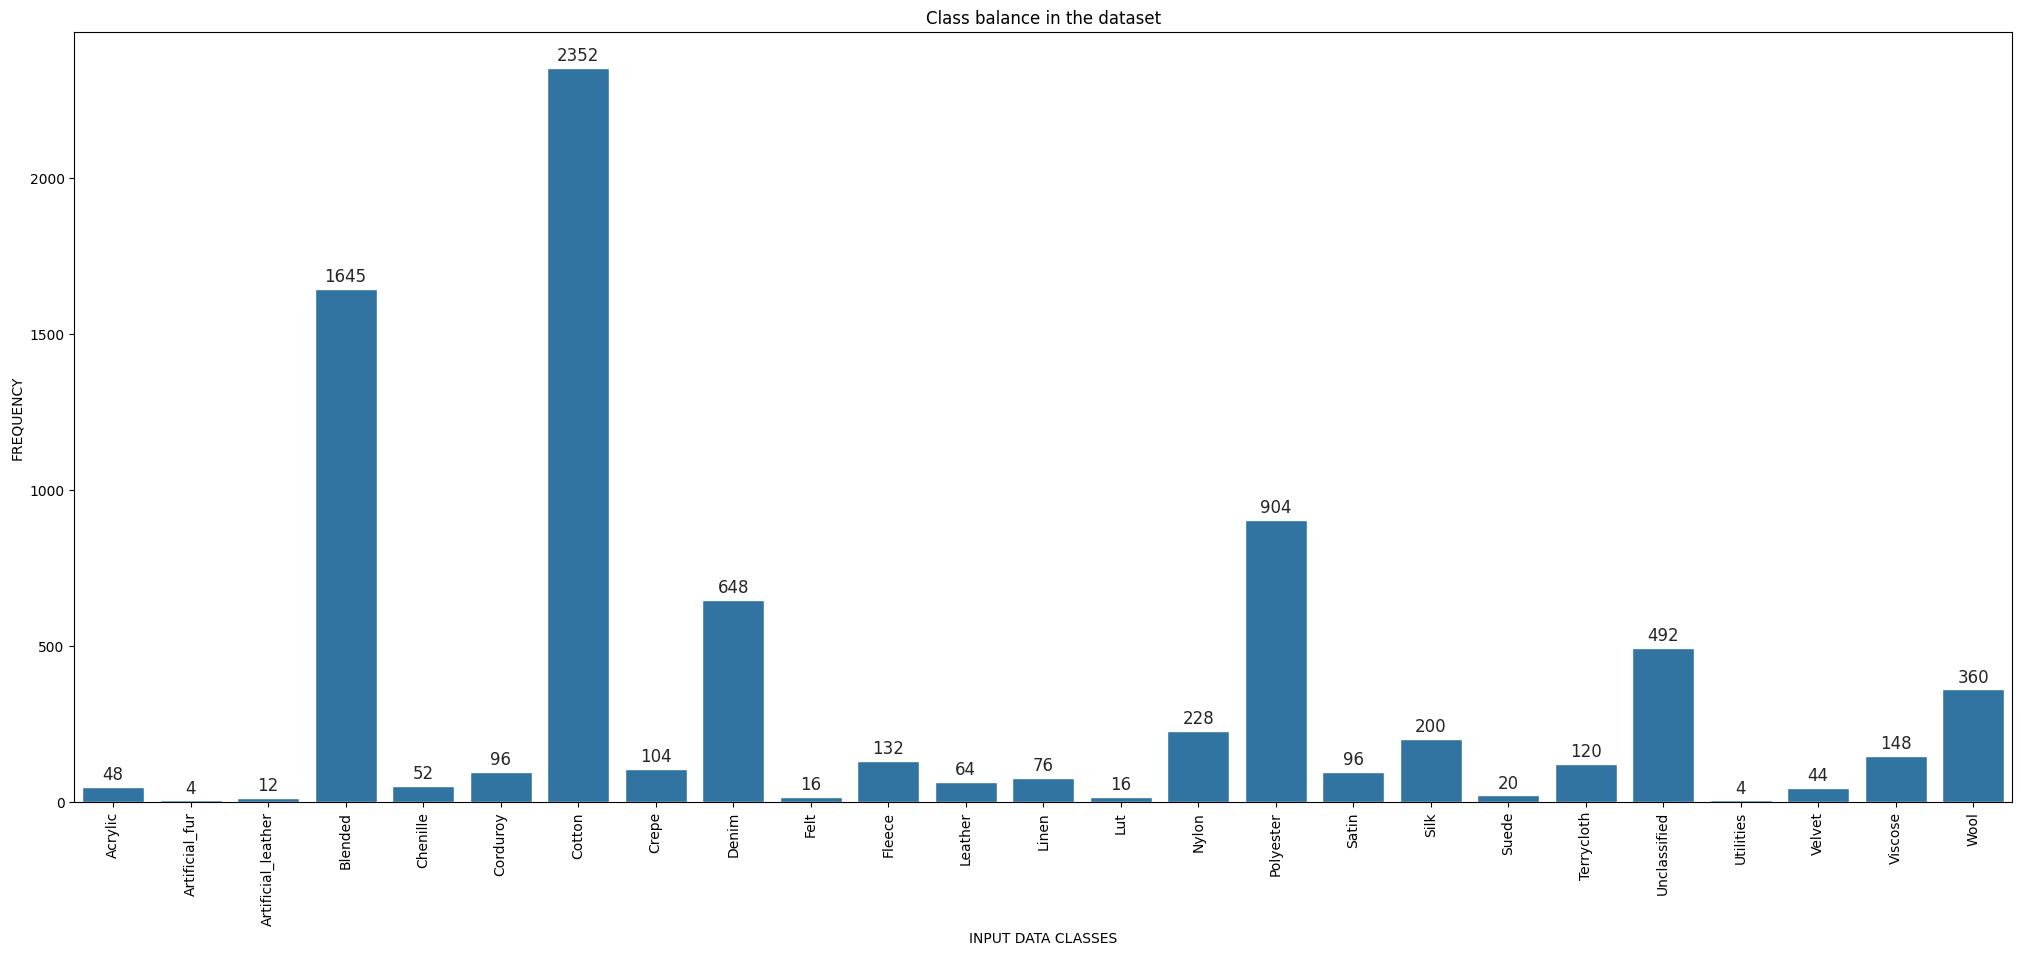

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))
values, counts = np.unique(input_labels, return_counts=True)
sns.set_theme()
ax = sns.barplot(x=values, y=counts)
ax.set_title("Class balance in the dataset")
ax.set_xlabel("INPUT DATA CLASSES")
ax.set_ylabel("FREQUENCY")
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')

plt.xticks(rotation=90)
plt.show()

<div class="markdown-google-sans">

**Nhận xét:**


---


- **Mất cân bằng giữa các lớp**: Có sự chênh lệch lớn về số lượng mẫu giữa các lớp. Một số lớp như **"Blended"** (1,645 mẫu), **"Cotton"** (2,352 mẫu), và **"Polyester"** (904 mẫu) có số lượng mẫu rất lớn, trong khi nhiều lớp khác như **"Artificial_fur", "Utilities",** và **"Suede"** chỉ có vài mẫu (4-20 mẫu). Điều này cho thấy dữ liệu không cân bằng, với một số lớp bị thiếu mẫu nghiêm trọng.

- Dữ liệu tập trung vào các lớp dữ liệu như "blended", "cotton", "denim" -> cần áp dụng các kĩ thuật như sampling (over-sampling, under-sampling) hoặc điều chỉnh trọng số khi huấn luyện mô hình. Bên cạnh đó các lớp như "Artificial_fur", "Utilities", "Suede" có rất ít mẫu, điều này có thể dẫn đến việc mô hình không học được đặc trưng của các lớp này.

- Blended (Vải pha)là loại vải kết hợp từ 2 hay nhiều loại vải khác nhau như Cotton và Polyester... Trong thí nghiệm này, chúng ta sẽ không sử dụng các loại quần áo làm từ vải pha trộn mà chỉ giữ lại những loại vải có thành phần 95% là một loại vật liệu.

- Lớp "Unclassified" chiếm số lượng đáng kể trong dữ liệu và bao gồm các mẫu vải chưa được phân loại rõ ràng. Điều này tạo ra thách thức cho mô hình học máy do tính không đồng nhất, nhưng cũng mở ra cơ hội để khám phá các loại vải mới. Cần xử lý lớp này cẩn thận để tránh ảnh hưởng tiêu cực đến hiệu suất mô hình.

 => Để đảm bảo mô hình học máy hoạt động hiệu quả trên tất cả các lớp,phần tiếp theo cần thực hiện một số bước như c**ân bằng dữ liệu, hoặc sử dụng các phương pháp học máy mạnh hơn (như kỹ thuật tăng cường) để xử lý dữ liệu không cân bằng.**









## **4. Preprocessing**

<div class="markdown-google-sans">

### ***4.1. Removing fabrics with very low sample size***


In [ ]:
data_df = data_df.loc[data_df['Label'].isin(["Cotton", "Denim", "Polyester", "Nylon", "Silk", "Wool"])]
data_df = data_df.reset_index(drop=True)
data_df

,Filepath,Label
0,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
1,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
2,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
3,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
4,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
...,...,...
4687,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
4688,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
4689,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
4690,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton


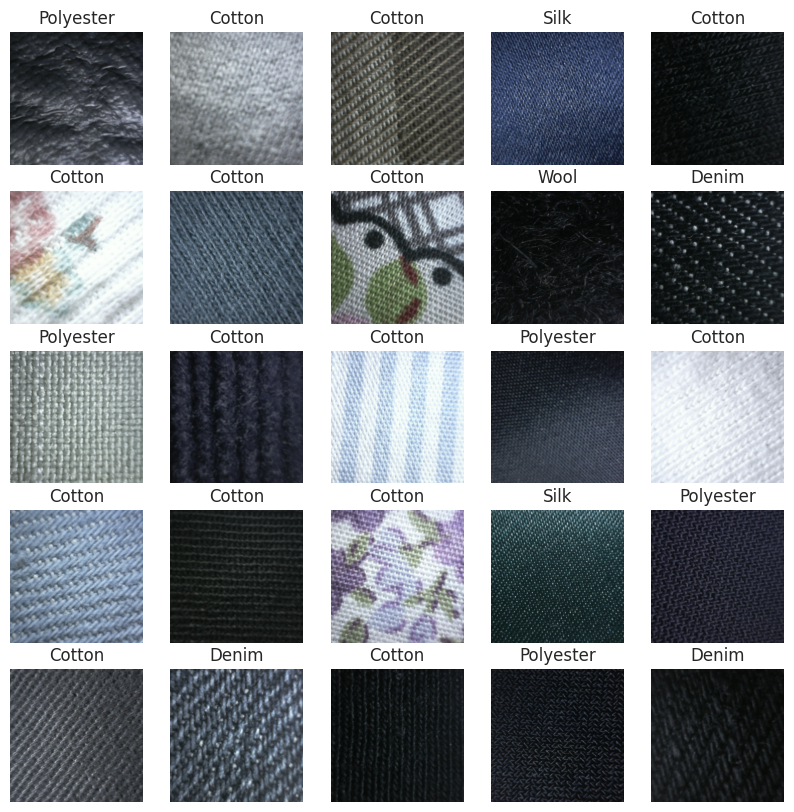

In [ ]:
random_index = np.random.randint(0, len(data_df), 25)
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    ax.imshow(plt.imread(data_df.Filepath[random_index[i]]))
    ax.set_title(data_df.Label[random_index[i]])
    plt.axis('off')
plt.show()

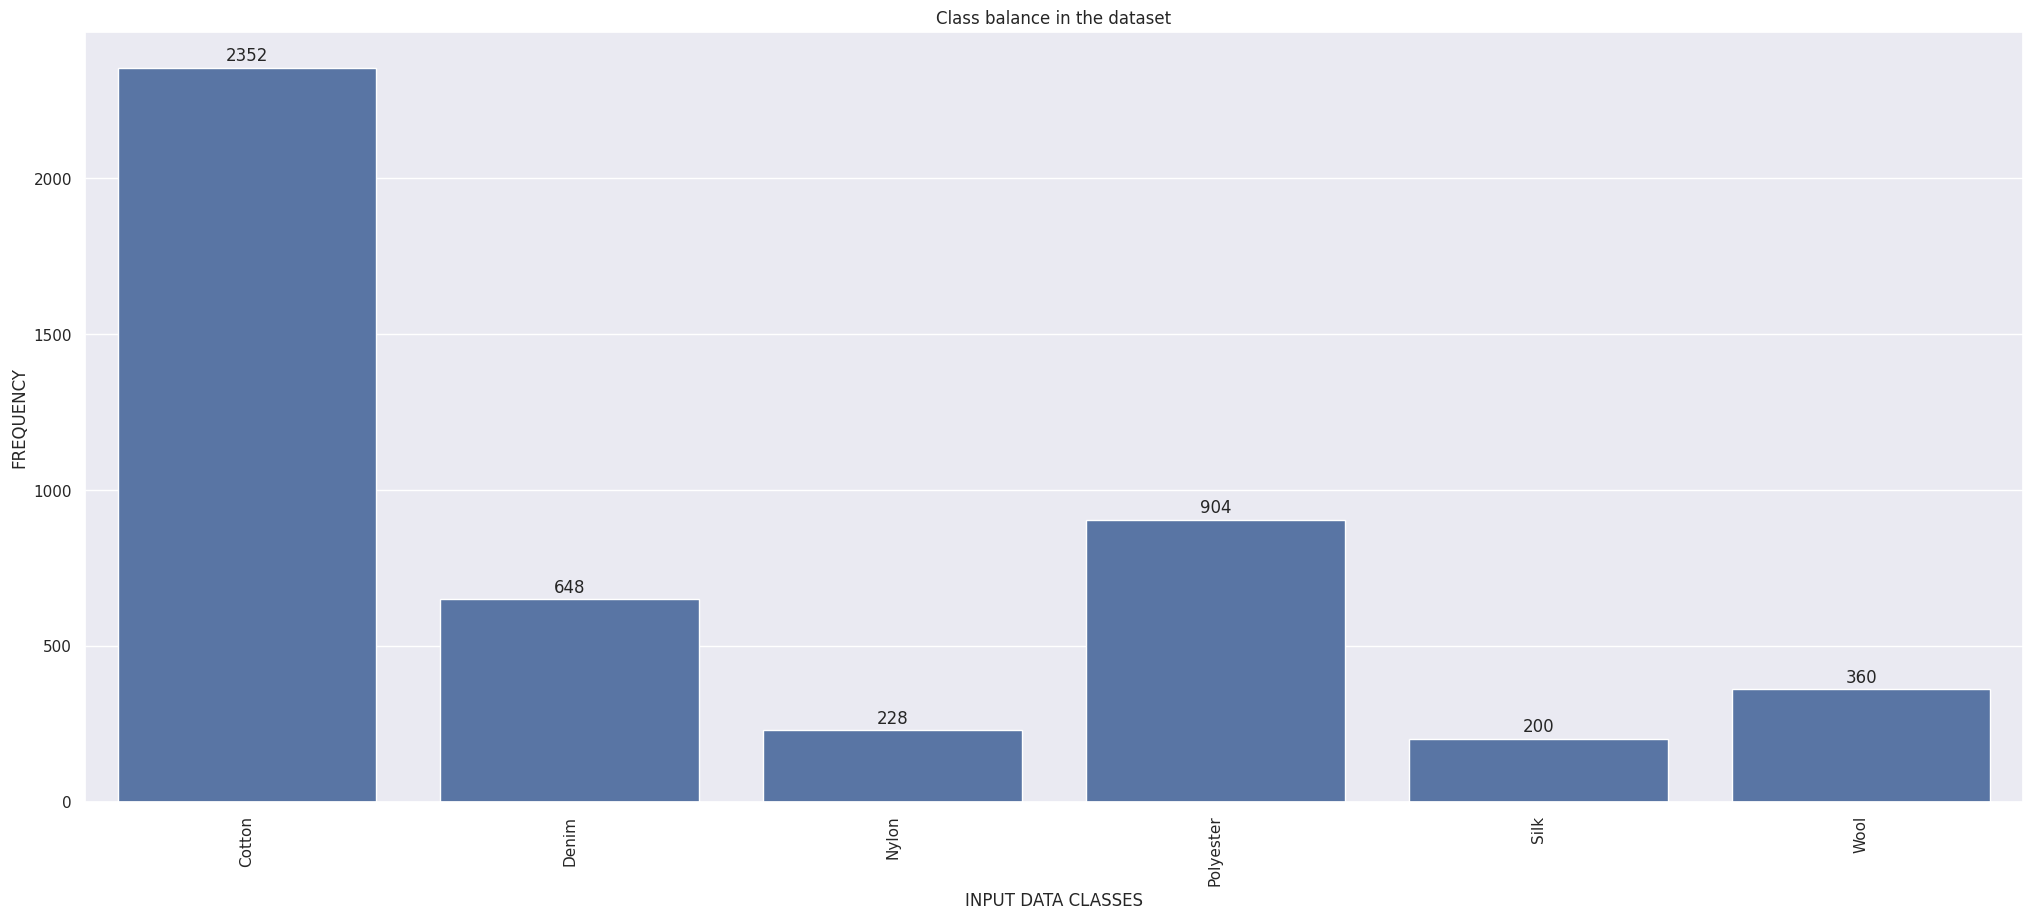

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))
values, counts = np.unique(data_df.Label.values.tolist(), return_counts=True)
sns.set_theme()
ax = sns.barplot(x=values, y=counts)
ax.set_title("Class balance in the dataset")
ax.set_xlabel("INPUT DATA CLASSES")
ax.set_ylabel("FREQUENCY")
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')

plt.xticks(rotation=90)
plt.show()

- chia dữ liệu

<div class="markdown-google-sans">

### 4.2. Improving the class balance through **Data Augmentation**


- train
- valid

Multi Step Augmentation to improve class balance. We perform this augmentation only on the training data, retaining the original fabric samples in the test dataset.



In [ ]:
train_df, test_df = train_test_split(data_df, test_size=0.2, stratify=data_df[['Label']], shuffle=True, random_state=SEED_VALUE)

In [ ]:
train_df

,Filepath,Label
4638,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
4185,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
1927,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Denim
3985,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
1186,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Polyester
...,...,...
4649,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
3182,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
1199,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Polyester
400,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Silk


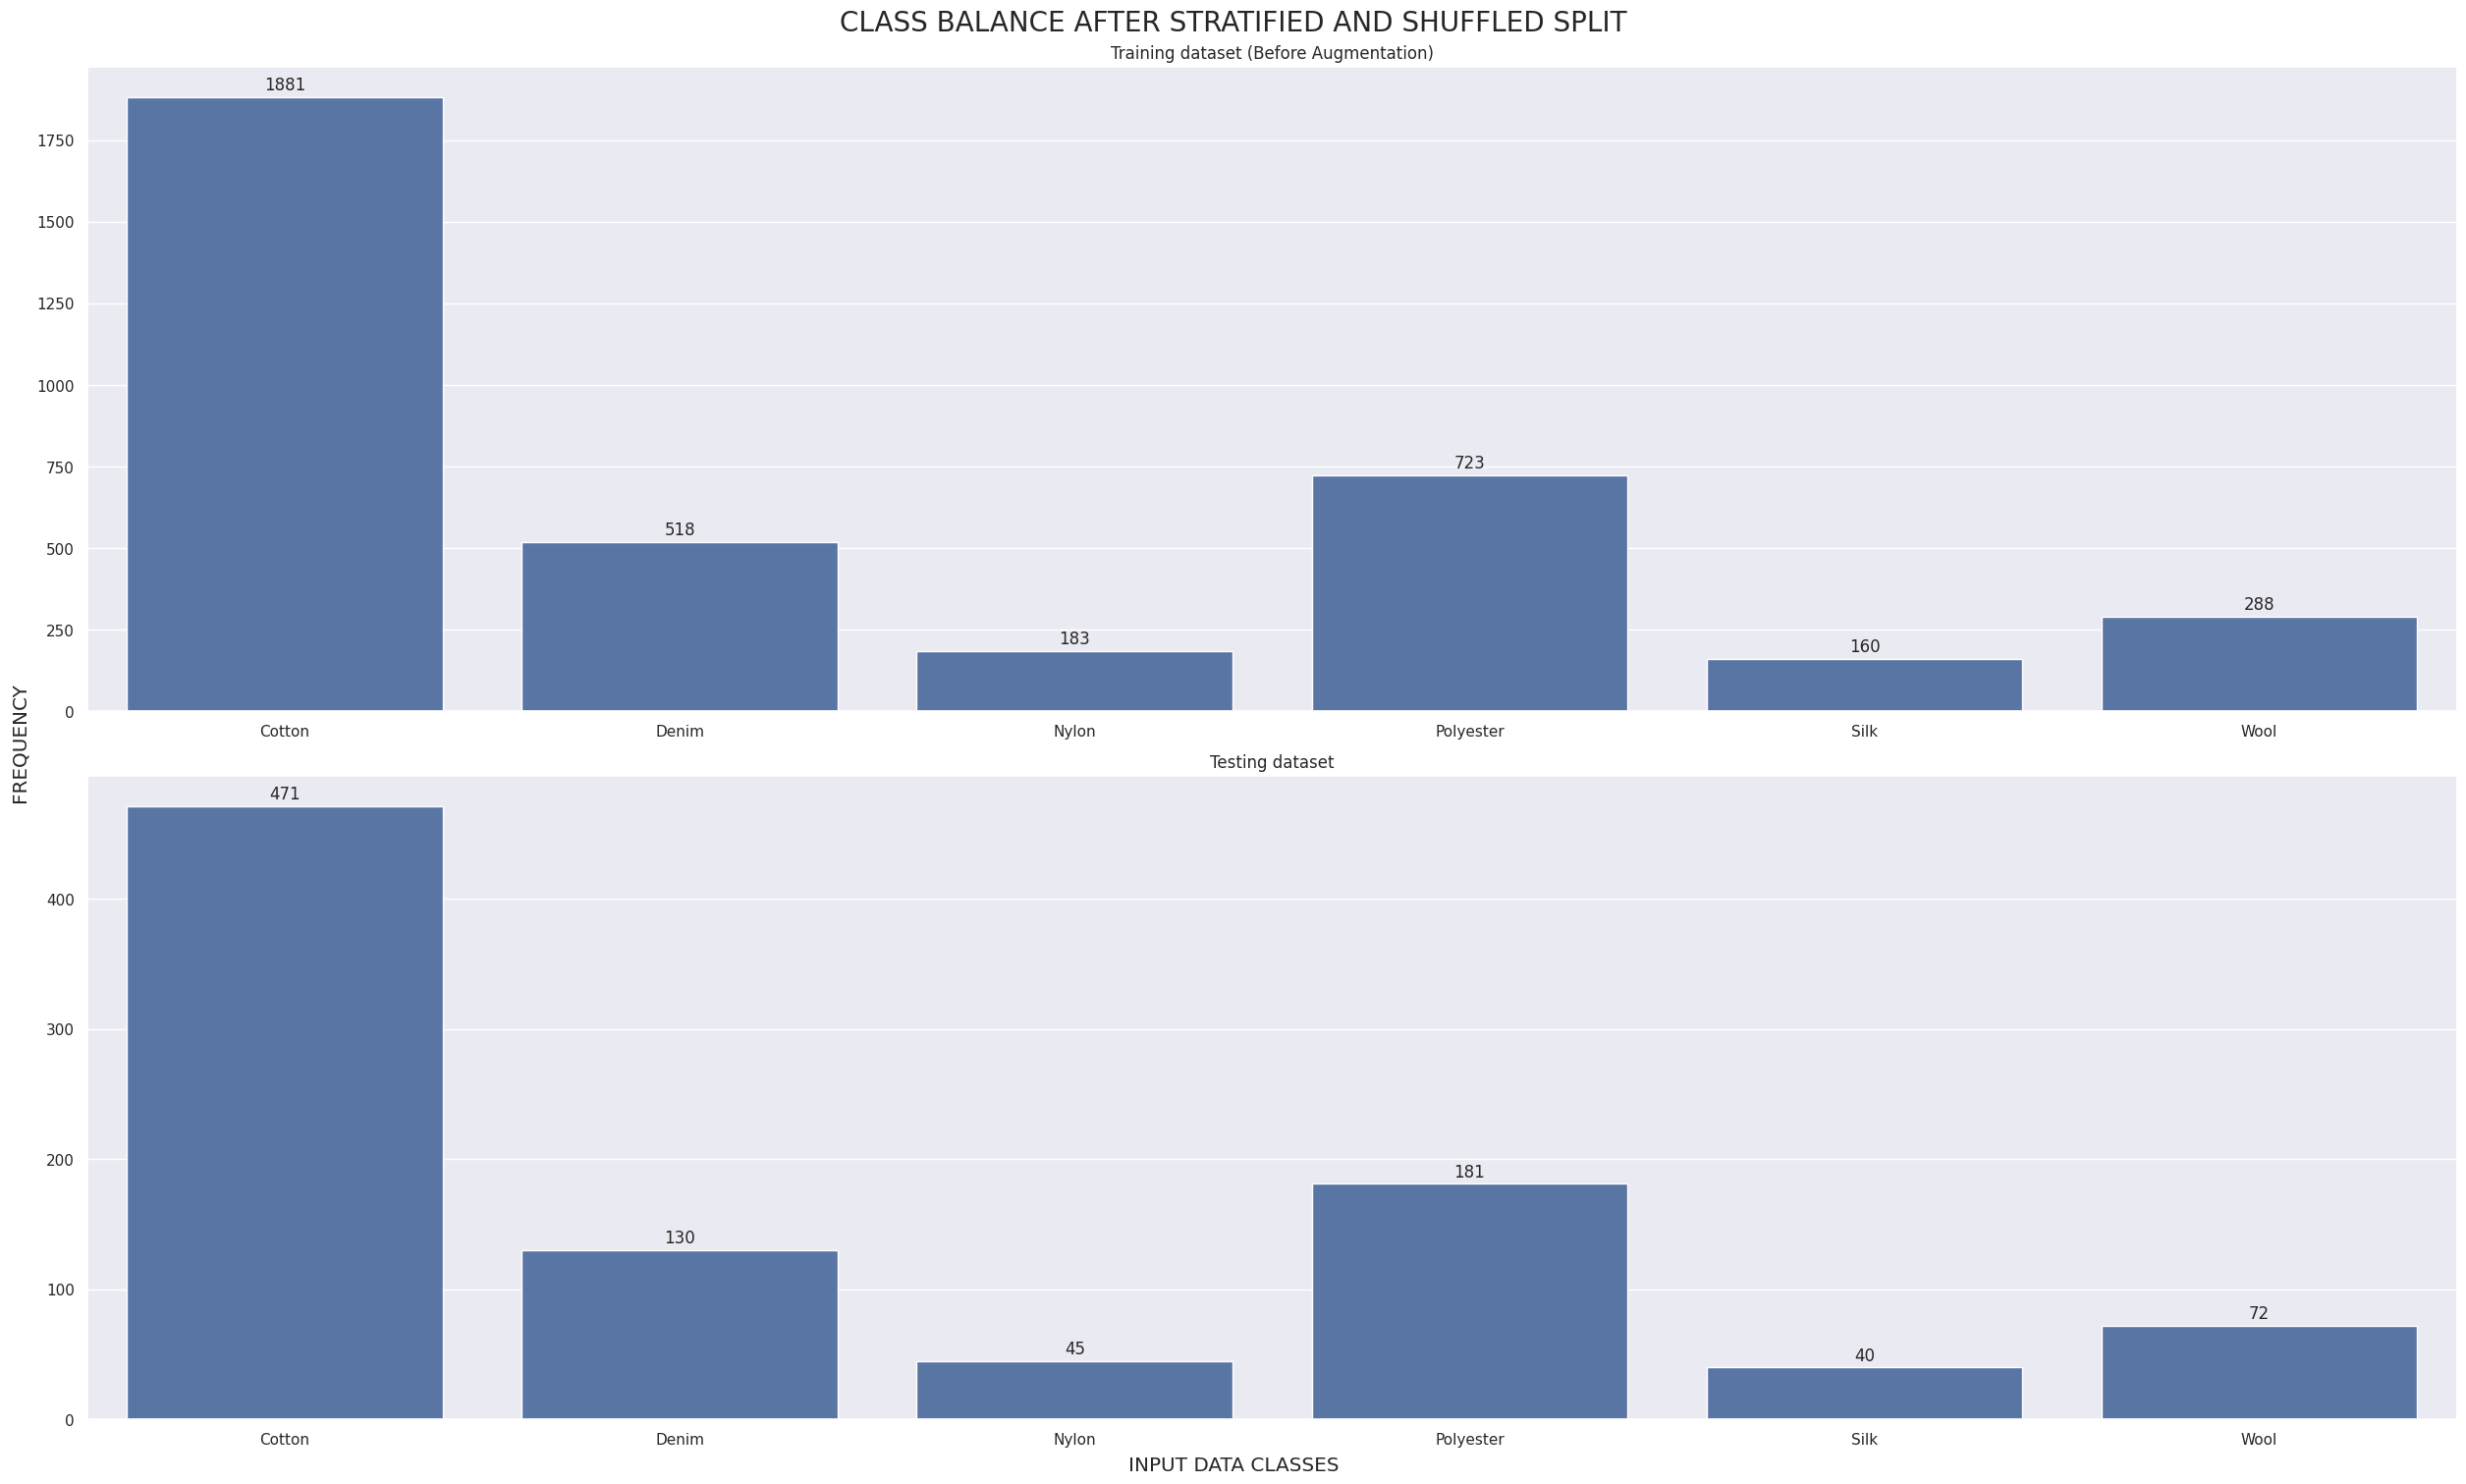

In [ ]:
# Class balance after stratify split
fig, axs = plt.subplots(2, 1, figsize=(25,15), layout='constrained')
fig.suptitle('CLASS BALANCE AFTER STRATIFIED AND SHUFFLED SPLIT', fontsize=20)
fig.supxlabel('INPUT DATA CLASSES')
fig.supylabel('FREQUENCY')
axs_list = axs.flatten()

# Class count in training dataset
train_values, train_counts = np.unique(train_df['Label'].tolist(), return_counts=True)
sns.barplot(ax=axs_list[0], x=train_values, y=train_counts).set(title='Training dataset (Before Augmentation)')
ax = axs_list[0]
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')

# Class count in testing dataset
test_values, test_counts = np.unique(test_df['Label'].tolist(), return_counts=True)
sns.barplot(ax=axs_list[1], x=test_values, y=test_counts).set(title='Testing dataset')
ax = axs_list[1]
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')

plt.show()

In [ ]:
# prompt: in ra phân phối train_df và test-df

print("Phân phối train_df:")
print(train_df['Label'].value_counts())
print("\nPhân phối test_df:")
print(test_df['Label'].value_counts())


Phân phối train_df:
Label
Cotton       1881
Polyester     723
Denim         518
Wool          288
Nylon         183
Silk          160
Name: count, dtype: int64

Phân phối test_df:
Label
Cotton       471
Polyester    181
Denim        130
Wool          72
Nylon         45
Silk          40
Name: count, dtype: int64


In [ ]:
print(train_df['Label'].value_counts())



Label
Cotton       1881
Polyester     723
Denim         518
Wool          288
Nylon         183
Silk          160
Name: count, dtype: int64


In [ ]:

# Đếm số lượng mẫu từ DataFrame train_df
train_df_counts = train_df['Label'].value_counts().to_dict()

# Số lượng mẫu mục tiêu là số lượng cao nhất trong các label
target_sample_count = max(train_df_counts.values())

In [ ]:
cur_dir = "/content/drive/MyDrive/Gr3_Fabric_Classification"


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# Đường dẫn đến thư mục lưu trữ ảnh augmented
data_augmented_directory = os.path.join(cur_dir, "data_augmented")

# Đếm số lượng mẫu từ DataFrame train_df
train_df_counts = train_df['Label'].value_counts().to_dict()

# Số lượng mẫu mục tiêu là số lượng cao nhất trong các label
target_sample_count = max(train_df_counts.values())  # Số lượng mẫu lớn nhất (1881 cho Cotton)

# Thông số augmentation cho từng cấp độ
augmentation_levels = {
    "level_1": {
        "rotation_range": 30,
        "width_shift_range": 0.1,
        "height_shift_range": 0.1,
        "shear_range": 0.2,
        "zoom_range": 0.1,
        "horizontal_flip": True
    },
    "level_2": {
        "rotation_range": 70,
        "width_shift_range": 0.15,
        "height_shift_range": 0.25,
        "shear_range": 0.1,
        "zoom_range": 0.2,
        "vertical_flip": True
    },
    "level_3": {
        "rotation_range": 10,
        "shear_range": 0.15,
        "zoom_range": [0.5, 1.0],
        "brightness_range": [0.2, 1.0],
        "vertical_flip": True
    }
}

def augment_data(level, label, temp_df, target_directory, needed_samples, max_per_level):
    os.makedirs(target_directory, exist_ok=True)  # Tạo thư mục nếu chưa tồn tại

    datagen = ImageDataGenerator(**augmentation_levels[level])

    data_gen = datagen.flow_from_dataframe(
        dataframe=temp_df,
        save_to_dir=target_directory,
        x_col='Filepath',
        y_col='Label',
        target_size=(400, 400),
        interpolation='bicubic',
        color_mode='rgb',
        class_mode='categorical',
        batch_size=1,  # Tạo từng ảnh một
        seed=42,
    )

    total_generated = 0

    # Tạo các ảnh cho đến khi đạt được số lượng cần thiết
    while total_generated < needed_samples:
        next(data_gen)  # Sinh thêm ảnh
        total_generated += 1

        # Kiểm tra điều kiện dừng
        if total_generated % 100 == 0:  # Cứ mỗi 100 ảnh tạo ra, in ra thông tin
            print(f"{level.capitalize()} - Generated {total_generated}/{needed_samples} images for {label}")

        # Kiểm tra xem số lượng đã đạt giới hạn tối đa cho cấp độ chưa
        if total_generated >= max_per_level:
            print(f"Reached max of {max_per_level} images for {level}. Stopping this level.")
            break

    print(f"Completed augmentation for {label} at {level}: {total_generated}/{needed_samples} images generated.")
    return total_generated

def apply_augmentation():
    for label, count in train_df_counts.items():
        # Tính toán số lượng mẫu cần thiết cho mỗi nhãn
        needed_samples = target_sample_count - count  # Cần đạt số lượng mẫu mục tiêu

        # Lặp qua các cấp độ augmentation
        for level in augmentation_levels.keys():
            # Lấy DataFrame cho lớp hiện tại
            temp_df = train_df[train_df['Label'] == label]
            batch_size = len(temp_df)

            # Nếu cần thêm mẫu, thực hiện augmentation
            if needed_samples > 0 and count < target_sample_count:
                target_directory = os.path.join(data_augmented_directory, label)  # Lưu vào thư mục cho label

                # Đặt giới hạn cho mỗi cấp độ
                if level == "level_1":
                    max_per_level = 500
                elif level == "level_2":
                    max_per_level = 500
                elif level == "level_3":
                    max_per_level = 700

                # Tính toán số mẫu tối đa có thể tạo ra ở cấp độ này
                samples_to_generate = min(needed_samples, max_per_level)

                generated = augment_data(level, label, temp_df, target_directory, samples_to_generate, max_per_level)

                needed_samples -= generated  # Cập nhật lại số lượng cần thiết
            else:
                print(f"{label} has enough samples; skipping augmentation.")

# Thực thi hàm để áp dụng augmentation
apply_augmentation()


Cotton has enough samples; skipping augmentation.
Cotton has enough samples; skipping augmentation.
Cotton has enough samples; skipping augmentation.
Found 723 validated image filenames belonging to 1 classes.
Level_1 - Generated 100/500 images for Polyester
Level_1 - Generated 200/500 images for Polyester
Level_1 - Generated 300/500 images for Polyester
Level_1 - Generated 400/500 images for Polyester
Level_1 - Generated 500/500 images for Polyester
Reached max of 500 images for level_1. Stopping this level.
Completed augmentation for Polyester at level_1: 500/500 images generated.
Found 723 validated image filenames belonging to 1 classes.
Level_2 - Generated 100/500 images for Polyester
Level_2 - Generated 200/500 images for Polyester
Level_2 - Generated 300/500 images for Polyester
Level_2 - Generated 400/500 images for Polyester
Level_2 - Generated 500/500 images for Polyester
Reached max of 500 images for level_2. Stopping this level.
Completed augmentation for Polyester at level

In [ ]:
# prompt: duyệt qua /content/drive/MyDrive/Gr3_Fabric_Classification/data_augmented và thống kê số ảnh trong các label

import os
data_augmented_directory = "/content/drive/MyDrive/Gr3_Fabric_Classification/data_augmented"

label_counts = {}
for label in os.listdir(data_augmented_directory):
  label_path = os.path.join(data_augmented_directory, label)
  if os.path.isdir(label_path):
    image_count = len([f for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, f))])
    label_counts[label] = image_count

print("Số lượng ảnh trong mỗi label:")
for label, count in label_counts.items():
  print(f"{label}: {count}")


Số lượng ảnh trong mỗi label:
Polyester: 1133
Denim: 1307
Wool: 1515
Nylon: 1619
Silk: 1622


In [ ]:
data_augmented_directory = "/content/drive/MyDrive/Gr3_Fabric_Classification/data_augmented"

input_filepaths_augmented = []
input_labels_augmented = []

for label in os.listdir(data_augmented_directory):
    label_path = os.path.join(data_augmented_directory, label)
    if os.path.isdir(label_path):
        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)
            if Path(image_name).suffix == '.png':
                input_filepaths_augmented.append(image_path)
                input_labels_augmented.append(label)

data_df_augmented = pd.DataFrame(list(zip(input_filepaths_augmented, input_labels_augmented)), columns =['Filepath', 'Label'])

print(data_df_augmented)


                                               Filepath      Label
0     /content/drive/MyDrive/Gr3_Fabric_Classificati...  Polyester
1     /content/drive/MyDrive/Gr3_Fabric_Classificati...  Polyester
2     /content/drive/MyDrive/Gr3_Fabric_Classificati...  Polyester
3     /content/drive/MyDrive/Gr3_Fabric_Classificati...  Polyester
4     /content/drive/MyDrive/Gr3_Fabric_Classificati...  Polyester
...                                                 ...        ...
7191  /content/drive/MyDrive/Gr3_Fabric_Classificati...       Silk
7192  /content/drive/MyDrive/Gr3_Fabric_Classificati...       Silk
7193  /content/drive/MyDrive/Gr3_Fabric_Classificati...       Silk
7194  /content/drive/MyDrive/Gr3_Fabric_Classificati...       Silk
7195  /content/drive/MyDrive/Gr3_Fabric_Classificati...       Silk

[7196 rows x 2 columns]


In [ ]:
data_df_augmented

,Filepath,Label
0,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Polyester
1,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Polyester
2,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Polyester
3,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Polyester
4,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Polyester
...,...,...
7191,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Silk
7192,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Silk
7193,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Silk
7194,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Silk


In [ ]:
import pandas as pd

# Giả định rằng train_df và data_df_augmented đã được định nghĩa trước đó

# Hợp nhất DataFrame
train_df = pd.concat([train_df, data_df_augmented], ignore_index=True)

# Kiểm tra kích thước DataFrame sau khi hợp nhất
print("Kích thước train_df sau khi hợp nhất:", train_df.shape)


Kích thước train_df sau khi hợp nhất: (10949, 2)


In [ ]:
train_df

,Filepath,Label
0,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
1,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
2,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Denim
3,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
4,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Polyester
...,...,...
10944,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Silk
10945,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Silk
10946,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Silk
10947,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Silk


In [ ]:
# prompt: in ra phân phối của train_df

print(train_df['Label'].value_counts())


Label
Cotton       1881
Polyester    1856
Denim        1825
Wool         1803
Nylon        1802
Silk         1782
Name: count, dtype: int64


<div class="markdown-google-sans">

### **4.3. Merging the augmented dataset**





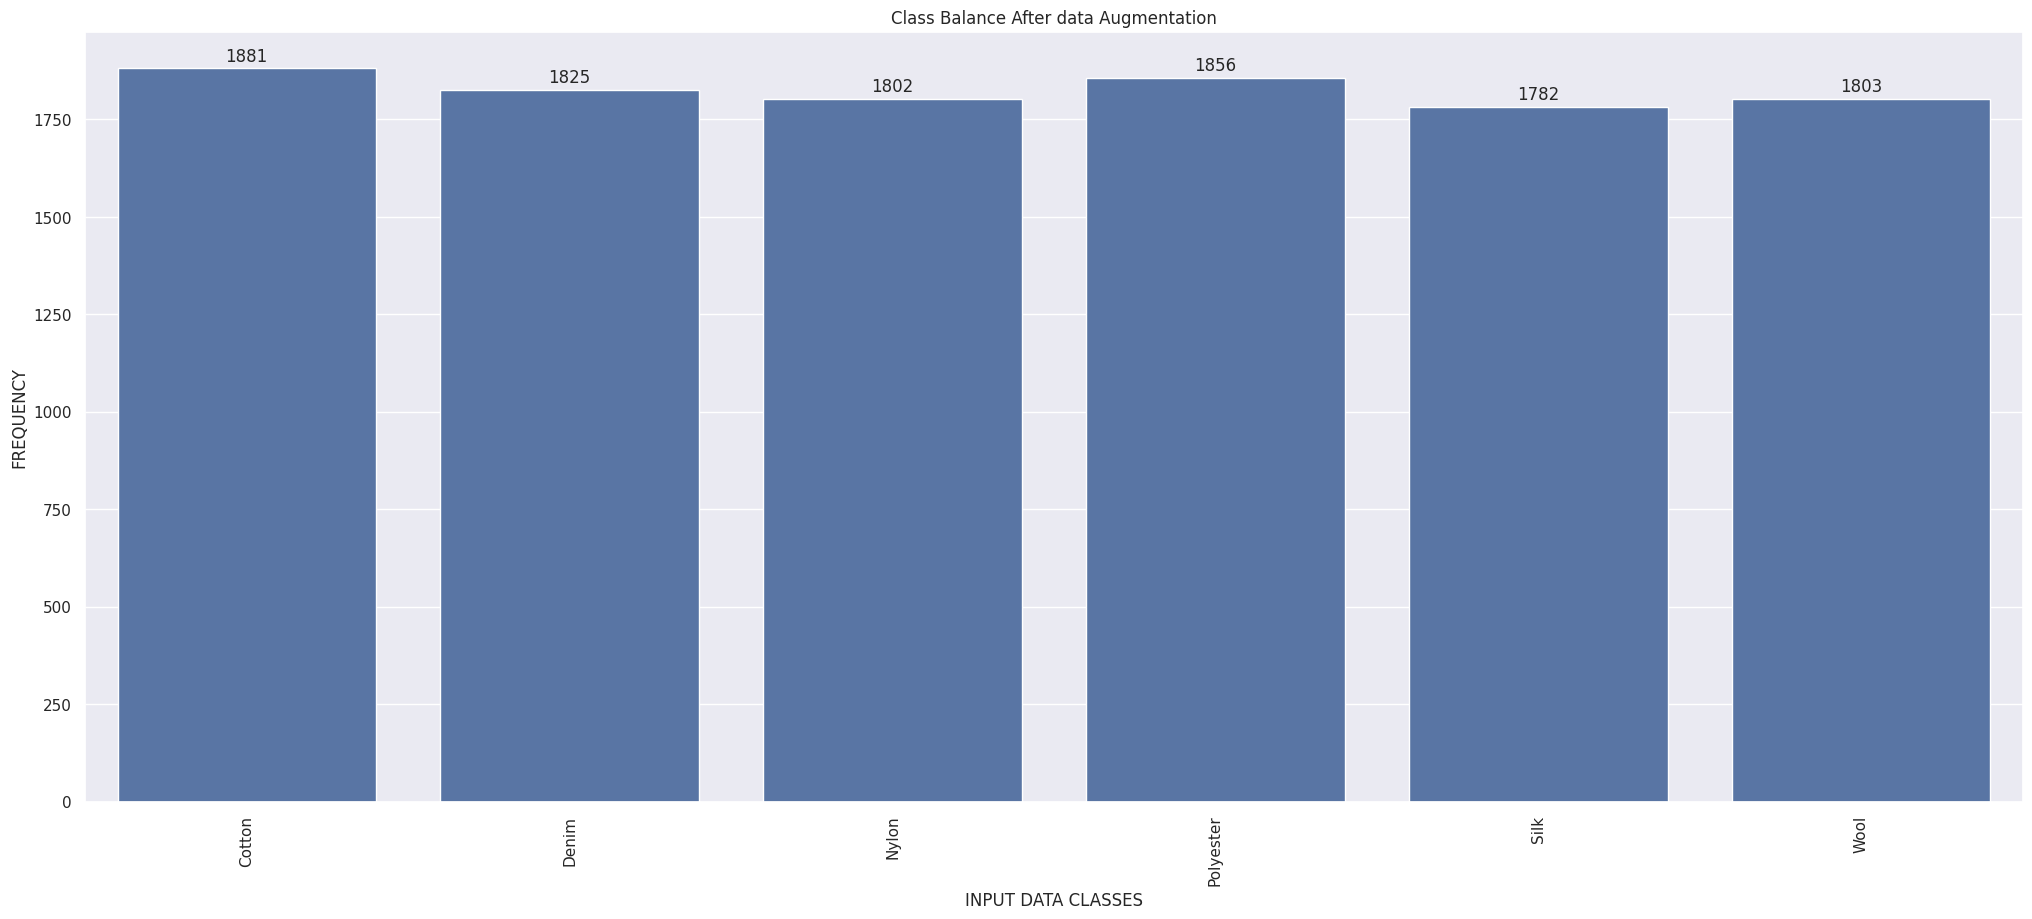

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))
values, counts = np.unique(train_df.Label.values.tolist(), return_counts=True)
sns.set_theme()
ax = sns.barplot(x=values, y=counts)
ax.set_title("Class Balance After data Augmentation")
ax.set_xlabel("INPUT DATA CLASSES")
ax.set_ylabel("FREQUENCY")
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')

plt.xticks(rotation=90)
plt.show()

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Đường dẫn đến thư mục lưu trữ ảnh augmented
data_augmented_directory = os.path.join(cur_dir, "data_augmented")

# Đếm số lượng mẫu từ DataFrame train_df
train_df_counts = train_df['Label'].value_counts().to_dict()

# Số lượng mẫu mục tiêu là số lượng cao nhất trong các label
target_sample_count = max(train_df_counts.values())  # Số lượng mẫu lớn nhất (1881 cho Cotton)

# Thông số augmentation cho cấp độ 3
augmentation_level_3 = {
    "rotation_range": 10,
    "shear_range": 0.15,
    "zoom_range": [0.5, 1.0],
    "brightness_range": [0.2, 1.0],
    "vertical_flip": True
}

def augment_data_level_3(label, temp_df, target_directory, needed_samples):
    os.makedirs(target_directory, exist_ok=True)  # Tạo thư mục nếu chưa tồn tại

    datagen = ImageDataGenerator(**augmentation_level_3)

    data_gen = datagen.flow_from_dataframe(
        dataframe=temp_df,
        save_to_dir=target_directory,
        x_col='Filepath',
        y_col='Label',
        target_size=(400, 400),
        interpolation='bicubic',
        color_mode='rgb',
        class_mode='categorical',
        batch_size=1,  # Tạo từng ảnh một
        seed=42,
    )

    total_generated = 0
    max_per_level = 500  # Giới hạn cho level 3

    # Tạo các ảnh cho đến khi đạt được số lượng cần thiết
    while total_generated < needed_samples:
        next(data_gen)  # Sinh thêm ảnh
        total_generated += 1

        # Kiểm tra điều kiện dừng
        if total_generated % 100 == 0:  # Cứ mỗi 100 ảnh tạo ra, in ra thông tin
            print(f"Level 3 - Generated {total_generated}/{needed_samples} images for {label}")

        # Kiểm tra xem số lượng đã đạt giới hạn tối đa cho cấp độ chưa
        if total_generated >= max_per_level:
            print(f"Reached max of {max_per_level} images for level 3. Stopping this level.")
            break

    print(f"Completed augmentation for {label} at level 3: {total_generated}/{needed_samples} images generated.")
    return total_generated

def apply_augmentation_level_3():
    for label, count in train_df_counts.items():
        # Tính toán số lượng mẫu cần thiết cho mỗi nhãn
        needed_samples = target_sample_count - count  # Cần đạt số lượng mẫu mục tiêu

        # Lấy DataFrame cho lớp hiện tại
        temp_df = train_df[train_df['Label'] == label]

        # Nếu cần thêm mẫu, thực hiện augmentation
        if needed_samples > 0 and count < target_sample_count:
            target_directory = os.path.join(data_augmented_directory, label)  # Lưu vào thư mục cho label

            generated = augment_data_level_3(label, temp_df, target_directory, needed_samples)

            needed_samples -= generated  # Cập nhật lại số lượng cần thiết
        else:
            print(f"{label} has enough samples; skipping level 3 augmentation.")

# Thực thi hàm để áp dụng augmentation cho cấp độ 3
apply_augmentation_level_3()


Cotton has enough samples; skipping level 3 augmentation.
Found 1358 validated image filenames belonging to 1 classes.
Level 3 - Generated 100/523 images for Polyester
Level 3 - Generated 200/523 images for Polyester
Level 3 - Generated 300/523 images for Polyester
Level 3 - Generated 400/523 images for Polyester
Level 3 - Generated 500/523 images for Polyester
Reached max of 500 images for level 3. Stopping this level.
Completed augmentation for Polyester at level 3: 500/523 images generated.
Found 1326 validated image filenames belonging to 1 classes.
Level 3 - Generated 100/555 images for Denim
Level 3 - Generated 200/555 images for Denim
Level 3 - Generated 300/555 images for Denim
Level 3 - Generated 400/555 images for Denim
Level 3 - Generated 500/555 images for Denim
Reached max of 500 images for level 3. Stopping this level.
Completed augmentation for Denim at level 3: 500/555 images generated.
Found 1303 validated image filenames belonging to 1 classes.
Level 3 - Generated 100

In [ ]:
# prompt: duyệt qua /content/drive/MyDrive/Gr3_Fabric_Classification/data_augmented và thống kê số ảnh trong các label

import os
data_augmented_directory = "/content/drive/MyDrive/Gr3_Fabric_Classification/data_augmented"

label_counts = {}
for label in os.listdir(data_augmented_directory):
  label_path = os.path.join(data_augmented_directory, label)
  if os.path.isdir(label_path):
    image_count = len([f for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, f))])
    label_counts[label] = image_count

print("Số lượng ảnh trong mỗi label:")
for label, count in label_counts.items():
  print(f"{label}: {count}")


Số lượng ảnh trong mỗi label:
Polyester: 1133
Denim: 1307
Wool: 1515
Nylon: 1619
Silk: 1622


### 4.4. Creating Train & Validation Datasets

*   Mục danh sách
*   Mục danh sách




In [ ]:
# Splitting the data into train & test datasets with stratification ; perform a bigger split
train_df, validation_df = train_test_split(train_df, test_size=0.1, shuffle=True, random_state=SEED_VALUE)

In [ ]:

train_df.to_csv(f"{cur_dir}/models/models_2/data/train.csv", index=False)
validation_df.to_csv(f"{cur_dir}/models/models_2/data/validation.csv", index=False)
test_df.to_csv(f"{cur_dir}/models/models_2/data/test.csv", index=False)


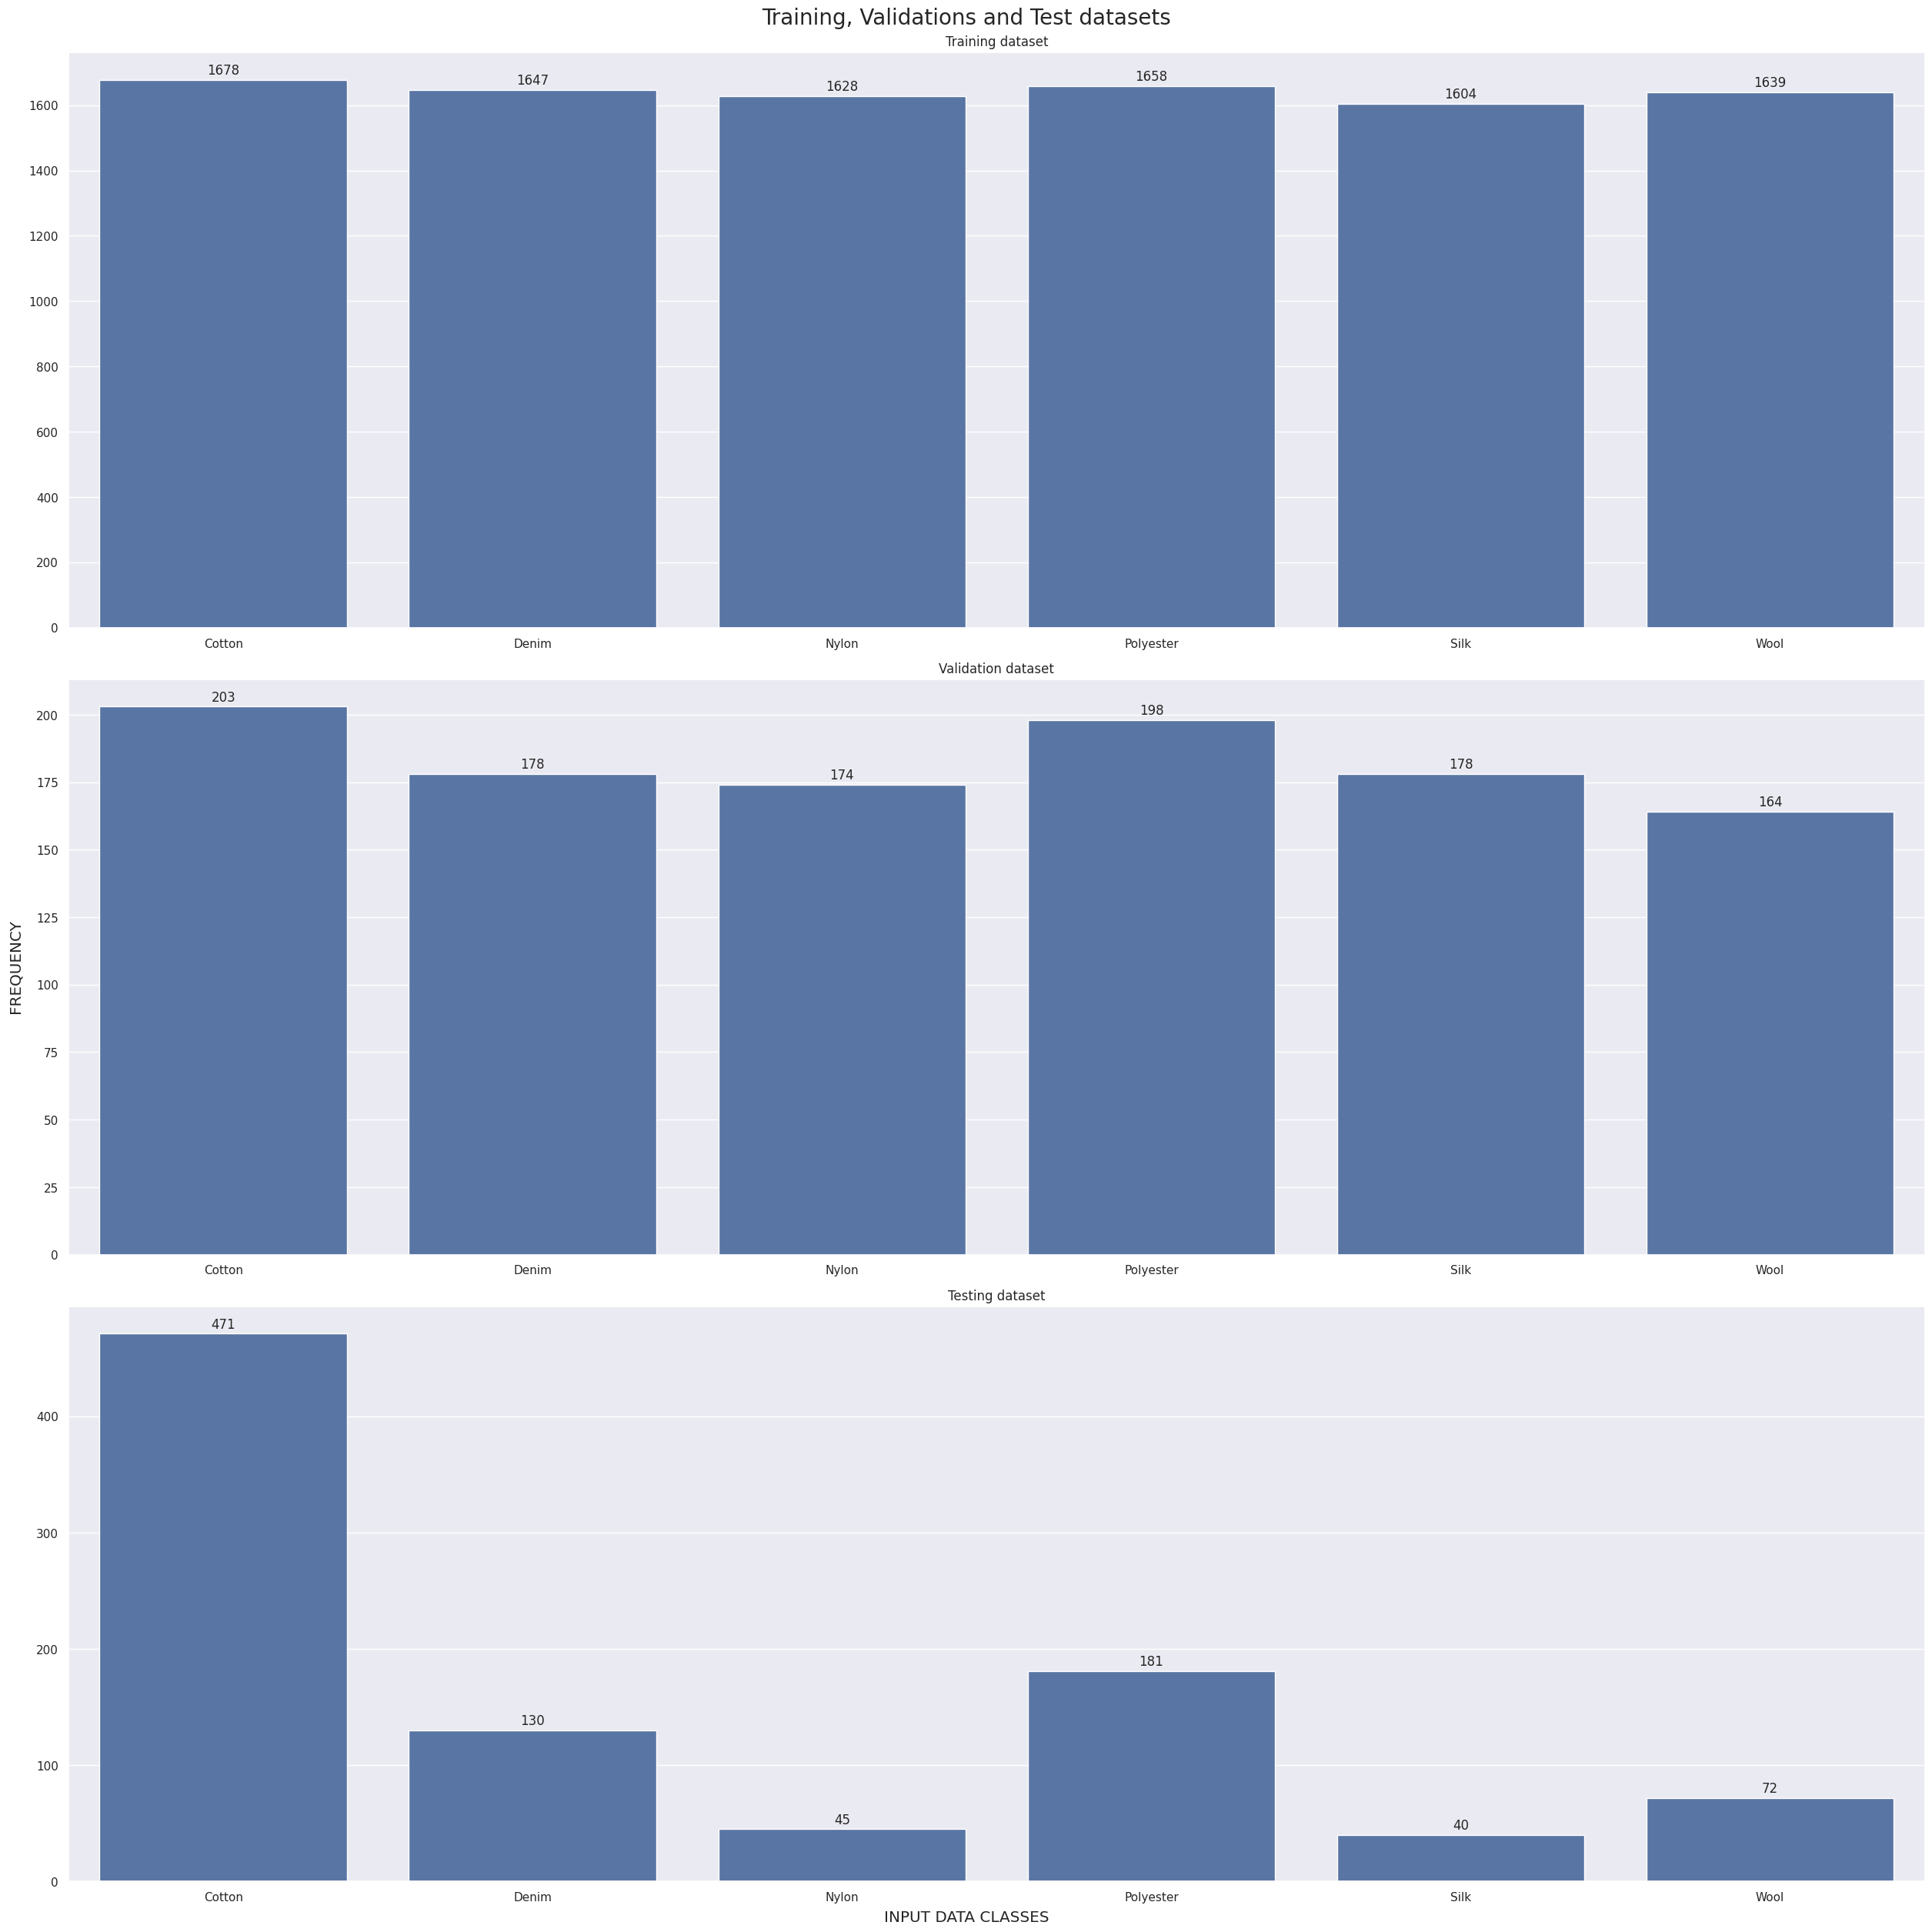

In [ ]:
# Class balance after stratify split
fig, axs = plt.subplots(3, 1, figsize=(25,25), layout='constrained')
fig.suptitle('Training, Validations and Test datasets', fontsize=20)
fig.supxlabel('INPUT DATA CLASSES')
fig.supylabel('FREQUENCY')
axs_list = axs.flatten()

# Class count in training dataset
train_values, train_counts = np.unique(train_df['Label'].tolist(), return_counts=True)
sns.barplot(ax=axs_list[0], x=train_values, y=train_counts).set(title='Training dataset')
ax=ax=axs_list[0]
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')

# Class count in validation dataset
validation_values, validation_counts = np.unique(validation_df['Label'].tolist(), return_counts=True)
sns.barplot(ax=axs_list[1], x=validation_values, y=validation_counts).set(title='Validation dataset')
ax=ax=axs_list[1]
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')

# Class count in testing dataset
test_values, test_counts = np.unique(test_df['Label'].tolist(), return_counts=True)
sns.barplot(ax=axs_list[2], x=test_values, y=test_counts).set(title='Testing dataset')
ax=ax=axs_list[2]
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')

plt.show()

In [ ]:
train_datagenerator = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input)

training_data = train_datagenerator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMG_ROWS, IMG_COLS), # downsampling the images
    interpolation='bicubic',
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    rescale=1.0/255,
    shuffle=True,
    seed=SEED_VALUE,
)

Found 9854 validated image filenames belonging to 6 classes.


In [ ]:
validation_datagenerator = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input)

validation_data = validation_datagenerator.flow_from_dataframe(
    dataframe=validation_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMG_ROWS, IMG_COLS), # downsampling the images
    interpolation='bicubic',
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    rescale=1.0/255,
    shuffle=True,
    seed=SEED_VALUE
)

Found 1095 validated image filenames belonging to 6 classes.


In [ ]:
test_datagenerator = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input)

test_data = test_datagenerator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMG_ROWS, IMG_COLS),
    interpolation='bicubic',
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=SEED_VALUE
)

Found 939 validated image filenames belonging to 6 classes.


In [ ]:
import pandas as pd
import numpy as np

# Hàm để lưu lại các giá trị đã được chuẩn hóa
def save_normalized_data(data_generator, dataframe, filename):
    # Lấy số lượng mẫu
    num_samples = len(dataframe)

    # Lấy ra các hình ảnh và nhãn đã được chuẩn hóa
    images = []
    labels = []

    for _ in range(num_samples):
        # Lấy một batch hình ảnh và nhãn
        batch_images, batch_labels = next(data_generator)

        # Lưu vào danh sách
        images.append(batch_images)
        labels.append(batch_labels)

    # Chuyển đổi thành mảng NumPy
    images_array = np.concatenate(images)
    labels_array = np.concatenate(labels)

    # Tạo DataFrame mới
    normalized_df = pd.DataFrame(images_array.reshape(num_samples, -1))  # Reshape để flatten hình ảnh
    normalized_df['Label'] = np.argmax(labels_array, axis=1)  # Lấy nhãn

    # Lưu DataFrame vào file CSV
    normalized_df.to_csv(filename, index=False)


# Lưu dữ liệu huấn luyện, xác thực và kiểm tra
save_normalized_data(training_data, train_df, f"{cur_dir}/normalized/normalized_training_data.csv")
save_normalized_data(validation_data, validation_df, f"{cur_dir}/normalized/normalized_validation_data.csv")
save_normalized_data(test_data, test_df, f"{cur_dir}/normalized/normalized_test_data.csv")


In [ ]:
!jupyter nbconvert --to html '/content/drive/MyDrive/Gr3_Fabric_Classification/ipynb/eda_preprocessing.ipynb'


[NbConvertApp] Converting notebook /content/drive/MyDrive/Gr3_Fabric_Classification/ipynb/test01_gr3_fabric.ipynb to html
[NbConvertApp] Writing 3193754 bytes to /content/drive/MyDrive/Gr3_Fabric_Classification/ipynb/test01_gr3_fabric.html
